In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score



### Data preparation


In [14]:
# Read the data
df = pd.read_csv('../data/processed_data_news_stock.csv')
df.dropna(inplace=True)

# Split the data into training and test sets based on the Date column
training_data = df.loc[df['Date'] < '2024-01-01']
test_data = df.loc[df['Date'] >= '2024-01-01']


In [15]:
# Feature selection: We are using 'Open', 'High', 'Low', 'Close', 'Volume', 'change', 'score', and 'label' as features
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'score', 'label']  # Including 'label' as input feature

# Normalize the features using MinMaxScaler (scaling values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
training_data[features] = scaler.fit_transform(training_data[features])
test_data[features] = scaler.transform(test_data[features])

/var/folders/n9/j0dtm7bn7_56lrscncyljw6m0000gn/T/ipykernel_20840/1889227094.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[features] = scaler.fit_transform(training_data[features])
/var/folders/n9/j0dtm7bn7_56lrscncyljw6m0000gn/T/ipykernel_20840/1889227094.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features] = scaler.transform(test_data[features])


In [16]:
# Function to create time series data (X, y)
def create_time_series(data, target_column, features, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[features].iloc[i:i + window_size].values)
        y.append(data[target_column].iloc[i + window_size])
    return np.array(X), np.array(y)

# Set window size (using the past 5 days to predict the next day's stock price)
window_size = 5  # Using past 5 days' data to predict the stock price of the next day

# Impute missing values with column mean
training_data[features] = training_data[features].fillna(training_data[features].mean())
test_data[features] = test_data[features].fillna(test_data[features].mean())

# Recreate the time series data after imputing missing values
X_train, y_train = create_time_series(training_data, target_column='Adj Close', features=features, window_size=window_size)
X_test, y_test = create_time_series(test_data, target_column='Adj Close', features=features, window_size=window_size)


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Reshape y_train
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

/var/folders/n9/j0dtm7bn7_56lrscncyljw6m0000gn/T/ipykernel_20840/2683914579.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[features] = training_data[features].fillna(training_data[features].mean())
/var/folders/n9/j0dtm7bn7_56lrscncyljw6m0000gn/T/ipykernel_20840/2683914579.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features] = test_data[features].fillna(test_data[features].mean())


In [17]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [18]:
# Check if MPS is available and set the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [20]:
from torch.utils.data import DataLoader, TensorDataset
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128  # Hidden layer size
num_layers = 2  # Number of LSTM layers
epochs = 200  # Number of epochs
batch_size = 64  # Batch size for training
learning_rate = 0.001  # Learning rate
patience = 10  # Early stopping patience

# Initialize the model
model = LSTMModel(input_size, hidden_size, num_layers)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Check for GPU
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)
# Create DataLoader for batching (Assuming X_train, y_train, X_test, y_test are tensors already)
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Early stopping parameters
best_val_loss = float('inf')
epochs_without_improvement = 0

# Train the model
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    
    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save model checkpoint
    else:
        epochs_without_improvement += 1

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping after {epoch+1} epochs")
        break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_inputs = X_test.to(device)
    test_predictions = model(test_inputs).squeeze().cpu().numpy()

# Calculate evaluation metrics
mse = mean_squared_error(y_test, test_predictions)
mape = mean_absolute_percentage_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

# Print evaluation metrics
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R²: {r2:.4f}")


Epoch [10/200], Train Loss: 33553.6170, Val Loss: 114041.7240
Epoch [20/200], Train Loss: 34837.7374, Val Loss: 114041.5143
Epoch [30/200], Train Loss: 32587.4078, Val Loss: 114041.3060
Epoch [40/200], Train Loss: 34365.2927, Val Loss: 114041.0885
Epoch [50/200], Train Loss: 33859.6229, Val Loss: 114040.8815
Epoch [60/200], Train Loss: 35443.6803, Val Loss: 114040.6673
Epoch [70/200], Train Loss: 34631.7444, Val Loss: 114040.4583
Epoch [80/200], Train Loss: 34619.6770, Val Loss: 114040.2435
Epoch [90/200], Train Loss: 33555.8718, Val Loss: 114040.0371
Epoch [100/200], Train Loss: 35040.3660, Val Loss: 114039.8268
Epoch [110/200], Train Loss: 35387.0956, Val Loss: 114039.6159
Epoch [120/200], Train Loss: 33290.9148, Val Loss: 114039.4076
Epoch [130/200], Train Loss: 34659.0798, Val Loss: 114039.1953
Epoch [140/200], Train Loss: 34050.9734, Val Loss: 114038.9857
Epoch [150/200], Train Loss: 35323.4435, Val Loss: 114038.7728
Epoch [160/200], Train Loss: 34303.0799, Val Loss: 114038.5651
E

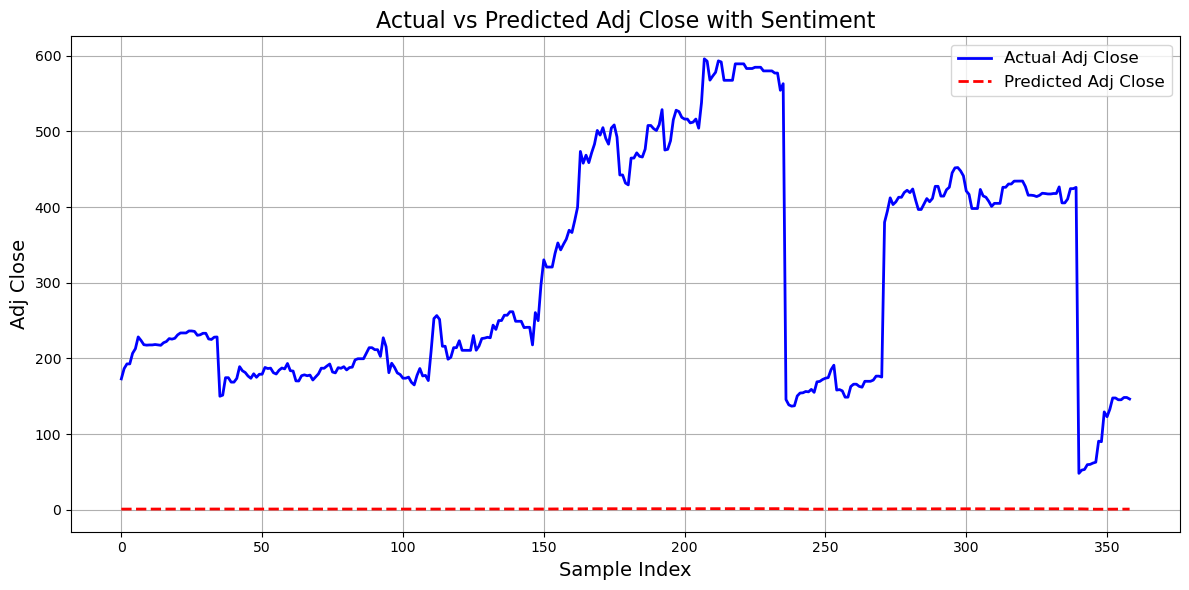

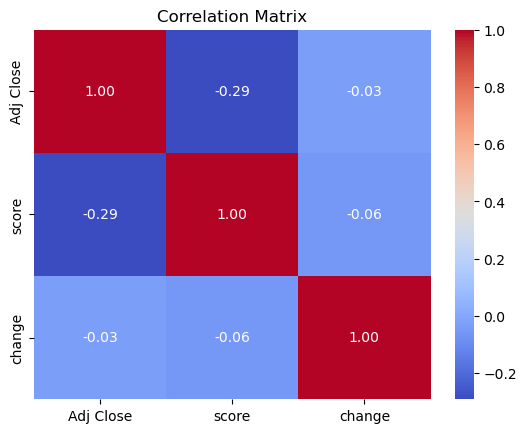

In [21]:
# Plot the actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Adj Close", color="blue", linewidth=2)
plt.plot(test_predictions, label="Predicted Adj Close", color="red", linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Adj Close with Sentiment", fontsize=16)
plt.xlabel("Sample Index", fontsize=14)
plt.ylabel("Adj Close", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the correlation matrix between stock price, sentiment score, and price change
correlation_matrix = df[['Adj Close', 'score', 'change']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()